In [2]:
import base64
import glob
import json

import boto3
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# get the list of images in "images" directory with relative path
images = glob.glob("images/*")
images

['images/good_08.png',
 'images/burnt_03.png',
 'images/chip_09.png',
 'images/burnt_04.png',
 'images/burnt_10.png',
 'images/burnt_05.png',
 'images/burnt_09.png',
 'images/chip_04.png',
 'images/burnt_08.png',
 'images/good_05.png',
 'images/chip_03.png',
 'images/burnt_06.png',
 'images/burnt_02.png',
 'images/chip_10.png',
 'images/burnt_07.png',
 'images/good_01.png',
 'images/chip_05.png',
 'images/chip_08.png',
 'images/good_07.png',
 'images/chip_02.png',
 'images/good_02.png',
 'images/burnt_01.png',
 'images/chip_07.png',
 'images/good_04.png',
 'images/good_03.png',
 'images/good_10.png',
 'images/chip_01.png',
 'images/chip_06.png',
 'images/good_09.png',
 'images/good_06.png']

In [4]:
classes = ["good", "burnt", "chip"]

In [5]:
bedrock_runtime = boto3.client('bedrock-runtime', region_name="us-east-1")

In [6]:
embedding_list = []
Y = []

for image in images:
    with open(image, "rb") as image_file:
        input_image = base64.b64encode(image_file.read()).decode("utf-8")

        body = json.dumps(
            {"inputText": "xxx", "inputImage": input_image, "embeddingConfig": {"outputEmbeddingLength": 256}}
        )

        response = bedrock_runtime.invoke_model(
            body=body,
            modelId="amazon.titan-embed-image-v1",
            accept="application/json",
            contentType="application/json",
        )

        response_body = json.loads(response.get("body").read())
        embedding = response_body.get("embedding")
        embedding_list.append(embedding)

        # get the class of the image from the image name
        image_class = image.split("/")[1].split("_")[0]
        Y.append(classes.index(image_class))

In [7]:
embedding_list

[[0.021512538,
  -0.033006098,
  -0.0014790855,
  -0.045719765,
  -0.00481712,
  0.01924942,
  -0.06689209,
  0.0030487515,
  0.0069254823,
  -0.00839375,
  -0.0038320753,
  0.009740051,
  -0.015909292,
  -0.13946182,
  0.015239335,
  -0.030120134,
  0.022568857,
  -0.06959097,
  -0.037048586,
  -0.031228965,
  0.05184701,
  -0.062463433,
  0.040063284,
  -0.046413034,
  0.025357407,
  0.05834389,
  -0.007117929,
  0.13378432,
  -0.033993218,
  0.00654066,
  0.064856395,
  -0.031283524,
  -0.02195235,
  0.0148551725,
  -0.048493147,
  0.014280988,
  -0.049882304,
  0.009227285,
  0.02508929,
  0.012047555,
  0.16284782,
  0.03463468,
  -0.07613279,
  0.024328288,
  0.00822118,
  -0.051610403,
  -0.038630456,
  0.0041704234,
  -0.073538885,
  -0.05729893,
  0.011779439,
  0.01116672,
  -0.12437856,
  0.010455195,
  -0.0025834367,
  0.016273495,
  -0.022139253,
  0.00786167,
  0.038467538,
  -0.004458599,
  -0.053858012,
  0.020343237,
  0.015468927,
  -0.027167339,
  -0.0072293086,
  -0

In [8]:
X = np.array(embedding_list)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, Y)

KNeighborsClassifier(n_neighbors=3)

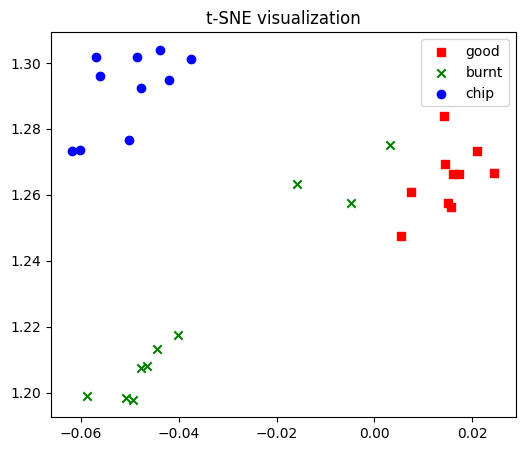

In [20]:
# visualize with t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

perplexity_value = min(30, len(X) - 1)

tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity_value)
# tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)

# visualize
plt.figure(figsize=(6, 5))
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']

# assuming class_names is your dictionary mapping class labels to names
class_names = {0: 'good', 1: 'burnt', 2: 'chip'}

for l, c, m in zip(np.unique(Y), colors, markers):
    plt.scatter(X_2d[Y == l, 0], X_2d[Y == l, 1], c=c, label=class_names[l], marker=m)
plt.title("t-SNE visualization")
plt.legend(loc='upper right')

plt.show()

In [21]:
test_images = glob.glob("test_images/*")

In [22]:
predictions = []

for test_image in test_images:
    with open(test_image, "rb") as image_file:
        input_image = base64.b64encode(image_file.read()).decode("utf-8")

        body = json.dumps(
            {"inputText": "xxx", "inputImage": input_image, "embeddingConfig": {"outputEmbeddingLength": 256}}
        )

        response = bedrock_runtime.invoke_model(
            body=body,
            modelId="amazon.titan-embed-image-v1",
            accept="application/json",
            contentType="application/json",
        )

        response_body = json.loads(response.get("body").read())
        embedding = response_body.get("embedding")

        embedding = np.array(embedding).reshape(1, -1)
        prediction = knn.predict(embedding)
        predictions.append(prediction[0])

        print(f"Prediction for {test_image}: {classes[prediction[0]]}")

Prediction for test_images/chip_14.png: chip
Prediction for test_images/burnt_12.png: good
Prediction for test_images/burnt_14.png: burnt
Prediction for test_images/chip_11.png: chip
Prediction for test_images/good_20.png: good
Prediction for test_images/good_11.png: good
Prediction for test_images/good_15.png: good
Prediction for test_images/chip_15.png: chip
Prediction for test_images/good_16.png: good
Prediction for test_images/burnt_15.png: burnt
Prediction for test_images/good_19.png: good
Prediction for test_images/good_17.png: good
Prediction for test_images/burnt_13.png: burnt
Prediction for test_images/good_18.png: good
Prediction for test_images/good_12.png: good
Prediction for test_images/chip_13.png: chip
Prediction for test_images/good_14.png: good
Prediction for test_images/chip_12.png: chip
Prediction for test_images/good_13.png: good
Prediction for test_images/burnt_11.png: burnt


In [23]:
# calculate accuracy
from sklearn.metrics import accuracy_score

correct_classes = [test_image.split("/")[1].split("_")[0] for test_image in test_images]
test_Y = [classes.index(test_class) for test_class in correct_classes]

accuracy = accuracy_score(test_Y, predictions)
accuracy

0.95

In [24]:
# calculate confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(test_Y, predictions)

array([[10,  0,  0],
       [ 1,  4,  0],
       [ 0,  0,  5]])